# Getting Started with IViS & MeerKAT

This notebook demonstrates a basic example of using IViS’s single-frequency model to perform imaging with mosaicking, using five MeerKAT beams.

> **Note:** IViS takes Measurement Sets as input and expects a set of Primary Beam FITS files to be placed in the `BEAMS/` directory.

## Download

You can download the data directory `data_tutorials` using:

```bash
wget https://www.mso.anu.edu.au/~amarchal/shared/ivis/data_tutorials.zip
unzip data_tutorials.zip -d data_tutorials
rm data_tutorials.zip
```

Kindly provided by Enrico Di Teodoro (UniFI) and Karlie Noon (RSAA/ANU).

## Using IViS

In [1]:
import glob
from tqdm import tqdm as tqdm

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from radio_beam import Beam
from astropy import units as u
from reproject import reproject_interp

from ivis.io import DataProcessor
from ivis.imager import Imager3D
from ivis.logger import logger
from ivis.readers import CasacoreReader
from ivis.types import VisIData
from ivis.utils import dutils, fourier

from ivis.models import ClassicIViS3D

In [2]:
path_ms = "./data_tutorials/ivis_data/msl_mw/" #directory of measurement sets    
path_beams = "./data_tutorials/ivis_data/BEAMS/" #directory of primary beams
path_sd = "./data_tutorials/ivis_data/" #path single-dish data
pathout = "./data_tutorials/ivis_data/" #path where data will be packaged and stored

In [3]:
#REF WCS INPUT USER
filename = "./data_tutorials/ivis_data/MW-C10_mom0th_NHI.fits"
target_header = fits.open(filename)[0].header
shape = (target_header["NAXIS2"],target_header["NAXIS1"])
    
#create data processor
data_processor = DataProcessor(path_ms, path_beams, path_sd, pathout)

[2025-08-25 07:25:56 UTC] [IViS] [info] [Initialize DataProcessor ]
[2025-08-25 07:25:56 UTC] [IViS] [info] -------------------------------------------------------------------------
[2025-08-25 07:25:56 UTC] [IViS] [info]  Timestamp: 2025-08-25 07:25:56 UTC
[2025-08-25 07:25:56 UTC] [IViS] [info] 
[2025-08-25 07:25:56 UTC] [IViS] [info]         _ _| \ \     / _)   ___| 
[2025-08-25 07:25:56 UTC] [IViS] [info]           |   \ \   /   | \___ \ 
[2025-08-25 07:25:56 UTC] [IViS] [info]           |    \ \ /    |       |
[2025-08-25 07:25:56 UTC] [IViS] [info]         ___|    \_/    _| _____/ 
[2025-08-25 07:25:56 UTC] [IViS] [info]         
[2025-08-25 07:25:56 UTC] [IViS] [info]  Version 1.0.0
[2025-08-25 07:25:56 UTC] [IViS] [info]  IViS is released as open-source software
[2025-08-25 07:25:56 UTC] [IViS] [info]  Author: @amarchal
[2025-08-25 07:25:56 UTC] [IViS] [info]  Documentation: https://ivis-dev.readthedocs.io/en/latest/
[2025-08-25 07:25:56 UTC] [IViS] [info]  Github: https://gith

### Precompute PB and interpolation grid for mosaicking

In [4]:
# pre-compute pb and interpolation grids — this can be commented after first compute
logger.disabled = True
data_processor.compute_pb_and_grid(target_header, fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits") 
logger.disabled = False

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


In [5]:
pb, grid = data_processor.read_pb_and_grid(fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits")

### Set SD data if needed (not used here)

In [6]:
#Dummy sd array
sd = np.zeros(shape)
#Dummy Beam sd
beam_sd = Beam(1*u.deg, 1*u.deg, 1.e-12*u.deg)

### Choose user parameters

In [7]:
#user parameters
max_its = 20
lambda_sd = 0
lambda_r = 1
cost_device = 0#"cpu" #0 is GPU and "cpu" is CPU
optim_device = 0#"cpu" #0 is GPU and "cpu" is CPU
positivity = False

In [8]:
#init parameters
init_params = np.zeros((1, shape[0], shape[1]), dtype=np.float32)

### Read data

In [9]:
# -------------------
# Read visibilities into VisIData dataclass
# -------------------
reader = CasacoreReader(
    prefer_weight_spectrum=False,
    keep_autocorr=False,
    n_workers=4)

I: VisIData = reader.read_blocks_I(
    path_ms,
    uvmin=0.0,
    uvmax=np.inf,
    chan_sel=slice(0, 1),
)

[2025-08-25 07:25:59 UTC] [IViS] [info] [BLOCK] Loading block from: ./data_tutorials/ivis_data/msl_mw/
[2025-08-25 07:25:59 UTC] [IViS] [info] [BLOCK] Loading 5 beam(s) from: ./data_tutorials/ivis_data/msl_mw/
[2025-08-25 07:25:59 UTC] [IViS] [info] [BLOCK] Parallel read with 4 workers (order-preserving; selective)
[2025-08-25 07:25:59 UTC] [IViS] [info]     [MS] Opening: ./data_tutorials/ivis_data/msl_mw/MW-C10_3_MW_chan_-32kms.ms
[2025-08-25 07:25:59 UTC] [IViS] [info]     [MS] Opening: ./data_tutorials/ivis_data/msl_mw/MW-C10_2_MW_chan_-32kms.ms
[2025-08-25 07:25:59 UTC] [IViS] [info]     [MS] Opening: ./data_tutorials/ivis_data/msl_mw/MW-C10_1_MW_chan_-32kms.ms
[2025-08-25 07:25:59 UTC] [IViS] [info]     [MS] Opening: ./data_tutorials/ivis_data/msl_mw/MW-C10_4_MW_chan_-32kms.ms
[2025-08-25 07:25:59 UTC] [IViS] [info]     [MS] Done: MW-C10_1_MW_chan_-32kms.ms  rows=626313
[2025-08-25 07:25:59 UTC] [IViS] [info]     [MS] Opening: ./data_tutorials/ivis_data/msl_mw/MW-C10_5_MW_chan_-32

### Initialize Imager and process

In [10]:
# create image processor
image_processor = Imager3D(I,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         sd,            # single dish data in unit of Jy/arcsec^2
                         beam_sd,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         init_params,   # init array of parameters
                         max_its,       # maximum number of iterations
                         lambda_sd,     # hyper-parameter single-dish        
                         positivity,    # impose a positivity constaint
                         cost_device,   # device: 0 is GPU; "cpu" is CPU
                         optim_device,
                         beam_workers=1)
# choose model
model = ClassicIViS3D(lambda_r=lambda_r, Nw=0)
# get image
result = image_processor.process(model=model, units="Jy/arcsec^2") #"Jy/arcsec^2" or "K"

[2025-08-25 07:26:00 UTC] [IViS] [info] CUDA unavailable or invalid index; using CPU.
[2025-08-25 07:26:00 UTC] [IViS] [info] CUDA unavailable or invalid index; using CPU.
[2025-08-25 07:26:00 UTC] [IViS] [info] [Initialize Imager3D       ]
[2025-08-25 07:26:00 UTC] [IViS] [info] Number of iterations to be performed by the optimizer: 20
[2025-08-25 07:26:00 UTC] [IViS] [warning] lambda_sd = 0 — No short-spacing correction.
[2025-08-25 07:26:00 UTC] [IViS] [info] Optimizer not bounded - Positivity == False
[2025-08-25 07:26:00 UTC] [IViS] [info] Units of output: Jy/arcsec^2.
[2025-08-25 07:26:00 UTC] [IViS] [info] Starting optimisation: PyTorch LBFGS on cpu (unconstrained); cost on cpu
[2025-08-25 07:26:11 UTC] [IViS] [info] [PID 58117] Iter cost: 2.051792e+06 (optim_dev=cpu, cost_dev=cpu)
[2025-08-25 07:26:12 UTC] [IViS] [info] [PID 58117] Iter cost: 1.943055e+06 (optim_dev=cpu, cost_dev=cpu)
[2025-08-25 07:26:14 UTC] [IViS] [info] [PID 58117] Iter cost: 1.884155e+06 (optim_dev=cpu, co

### Compute effective PB for mosaic

In [11]:
#mean pb
filenames = sorted(glob.glob(path_beams+"*.fits"))
n_beams = len(filenames)
pb_all = np.zeros((n_beams,result[0].shape[0],result[0].shape[1]))
w = dutils.wcs2D(target_header)
for i in tqdm(np.arange(n_beams)):
    #open beam cube
    hdu_pb = fits.open(filenames[i])
    hdr_pb = hdu_pb[0].header
    pb2 = hdu_pb[0].data
    pb2[pb2 != pb2] = 0.
    w_pb = dutils.wcs2D(hdr_pb)
    pb2, footprint = reproject_interp((pb2,w_pb.to_header()), w.to_header(), shape)
    pb2[pb2 != pb2] = 0.
    pb_all += pb2
    pb_mean = np.nanmean(pb_all,0)
    pb_mean /= np.nanmax(pb_mean)    
    mask = np.where(pb_mean > 0.05, 1, np.nan)

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/it]


### Plot result

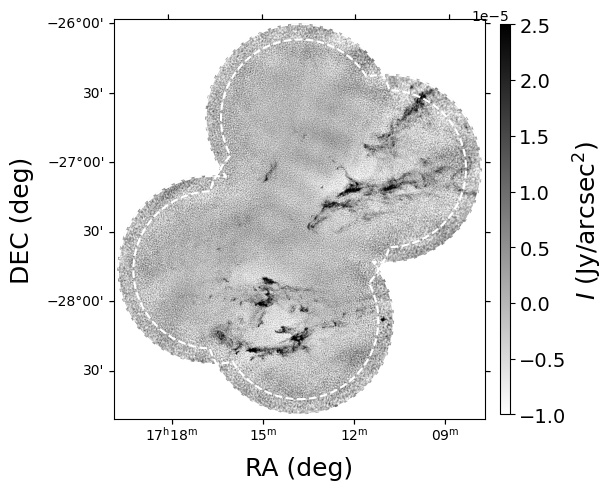

In [12]:
#PLOT RESULT
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"RA (deg)", fontsize=18.)
ax.set_ylabel(r"DEC (deg)", fontsize=18.)
img = ax.imshow(result[0]*mask, vmin=-1.e-5, vmax=2.5e-5, origin="lower", cmap="gray_r")
ax.contour(pb_mean, linestyles="--", levels=[0.05, 0.2], colors=["w","w"])
colorbar_ax = fig.add_axes([0.89, 0.11, 0.02, 0.78])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$I$ (Jy/arcsec$^{2})$", fontsize=18.)
#    plt.savefig(pathout + 'ivis_result_cloud_MeerKAT.png', format='png', bbox_inches='tight', pad_inches=0.02, dpi=400)